# Fracture Classification with Datamint and FracAtlas Dataset

This notebook demonstrates how to build an end-to-end binary classification pipeline using **Datamint** and the **FracAtlas** dataset. You will learn how to:

1. **Set up a Datamint project** for managing medical imaging data
2. **Download and upload** the FracAtlas dataset to Datamint
3. **Create annotations** for classification tasks
4. **Build a PyTorch Dataset** that integrates with Datamint
5. **Train a ResNet-18 model** using PyTorch Lightning
6. **Track experiments** with MLflow integration
7. **Deploy the model** for inference using Datamint's model serving

## Required Dependencies

```bash
pip install datamint
```

## Dataset Overview

The **FracAtlas** dataset contains 4,083 musculoskeletal radiographs annotated for fracture detection, localization, and segmentation. In this notebook, we focus on **binary classification**: determining whether an X-ray image shows a fracture or not.

In [1]:
from datamint import Api

PROJECT_NAME = "FracAtlas"
api = Api()

## 1. Setup: Create Project and Upload Dataset

In this section, we will:
- Create a new Datamint project (or retrieve an existing one)
- Download the FracAtlas dataset from Figshare
- Upload images to Datamint with appropriate tags
- Create classification annotations for each image

In [2]:
from datamint.mlflow import set_project

proj = api.projects.get_by_name(PROJECT_NAME)
if proj is None:
    print(f"Creating project '{PROJECT_NAME}'")
    proj = api.projects.create(name=PROJECT_NAME,
                               description="Project to train a binary classification model on FracAtlas dataset")
    
set_project(PROJECT_NAME) # important for proper experiment tracking

Creating project 'FracAtlas'


Project(id='f97c6fc8-f5fe-4191-a37b-eccfbb81dac7', name='FracAtlas', created_at='2025-12-03T02:09:00.363Z', created_by='datamint-dev@mail.com', dataset_id='0500d9ff-5d29-4fc5-a7e8-a6295e5f348d', worklist_id='b3402279-ebfc-4c49-b7cf-e89850431789', archived=False, resource_count=0, annotated_resource_count=0, description='Project to train a binary classification model on FracAtlas dataset', viewable_ai_segs=None, editable_ai_segs=None, closed_resources_count=0, resources_to_annotate_count=0, most_recent_experiment=None, annotators=[{'email': 'datamint-dev@mail.com', 'roles': ['PROJECT_OWNER'], 'status': 'active'}])

### 1.1 Download FracAtlas Dataset

The FracAtlas dataset is publicly available on Figshare. We'll download and extract it programmatically.

**Dataset Source:** [Figshare Repository](https://doi.org/10.6084/m9.figshare.22363012)

**Citation:** 
> Abedeen, I., et al. (2023). FracAtlas: A Dataset for Fracture Classification, Localization and Segmentation of Musculoskeletal Radiographs. Scientific Data, 10(1). doi:10.1038/s41597-023-02432-4

> [!Note]
> The download may take a few minutes depending on your internet connection (~1.2 GB compressed).


In [3]:
import requests
import zipfile
import os

# Retrieve and download FracAtlas dataset from Figshare
# It might take a while depending on your internet connection. ~50 seconds on a 100Mbps connection
r = requests.get('https://api.figshare.com/v2/articles/22363012')
if r.status_code == 200:
    file_metadata = r.json()['files'][0]
    file_name = file_metadata['name']
    print(f'Downloading {file_name}...')
    
    # Download and extract
    r = requests.get(file_metadata['download_url'], allow_redirects=True)
    with open(file_name, 'wb') as f:
        f.write(r.content)
    
    print(f'Unzipping {file_name}...')
    with zipfile.ZipFile(file_name, 'r') as zip_ref:
        zip_ref.extractall(os.path.splitext(file_name)[0])
else:
    print('Error:', r.text)

KeyboardInterrupt: 

### 1.2 Dataset Structure

The extracted dataset has the following structure:

```
FracAtlas/
├── images/
│   ├── Fractured/          # 717 images with visible fractures
│   │   ├── IMG0000110.jpg
│   │   └── ...
│   └── Non_fractured/      # 3,366 images without fractures
│       ├── IMG0002341.jpg
│       └── ...
└── ...
```

For this binary classification task, we'll use only the `images` folder, treating:
- `Fractured/` → Positive class (label: `has_fracture: yes`)
- `Non_fractured/` → Negative class (label: `has_fracture: no`)

In [4]:
from pathlib import Path
import os

# get all non-fractured images
non_fractured_root_path = Path('FracAtlas/FracAtlas/images/Non_fractured/')
fractured_root_path = Path('FracAtlas/FracAtlas/images/Fractured/')
non_fractured_images_paths = [str(non_fractured_root_path / img) for img in os.listdir(non_fractured_root_path)]
fractured_images_paths = [str(fractured_root_path / img) for img in os.listdir(fractured_root_path)]

print(f'Found {len(non_fractured_images_paths)} non-fractured images')
print(f'Found {len(fractured_images_paths)} fractured images')

Found 3366 non-fractured images
Found 717 fractured images


In [5]:
# Upload non-fractured images to Datamint
# Tags are optional and arbitrary, but help organize and filter resources later:
# 'fracatlas' - identifies dataset source
# 'non-fractured' - identifies class for annotation creation
new_resources_list = api.resources.upload_resources(non_fractured_images_paths,
                                                    tags=['fracatlas', 'non-fractured'],
                                                    publish_to=proj,  # associate the resources to the project
                                                    progress_bar=True)

Uploading resources:   0%|          | 0/3366 [00:00<?, ?file/s]

In [6]:
# Upload fractured images to Datamint
new_resources_list = api.resources.upload_resources(fractured_images_paths,
                                                    tags=['fracatlas', 'fractured'],
                                                    publish_to=proj,  # associate the resources to the project
                                                    progress_bar=True)

Uploading resources:   0%|          | 0/717 [00:00<?, ?file/s]

### 1.3 Create Classification Annotations

Now we'll create structured annotations for each image.

In [7]:
from tqdm.auto import tqdm

# Annotate non-fractured images with 'has_fracture: no'
nonfrac_resources_list = api.resources.get_list(project_name=PROJECT_NAME,
                                                tags=['non-fractured'])
for res in tqdm(nonfrac_resources_list):
    api.annotations.create_image_classification(resource=res,
                                                identifier='has_fracture',
                                                value='no')
# Annotate fractured images with 'has_fracture: yes'
frac_resources_list = api.resources.get_list(project_name=PROJECT_NAME,
                                             tags=['fractured'])
for res in tqdm(frac_resources_list):
    api.annotations.create_image_classification(resource=res,
                                                identifier='has_fracture',
                                                value='yes')

  0%|          | 0/3366 [00:00<?, ?it/s]

  0%|          | 0/717 [00:00<?, ?it/s]

In [8]:
# Inspect a sample resource to verify the upload
frac_resources_list[0]

Resource(id='d5997429-db13-491b-9136-7f2831deae1c', filename='IMG0004370.jpg', modality='Unknown', status='inbox', published=False)

In [9]:
# Verify that annotations were created correctly
# The annotation should show identifier='has_fracture' and value='yes' or 'no'
api.annotations.get_list(resource=frac_resources_list[0])[0].asdict()

{'identifier': 'has_fracture',
 'scope': 'image',
 'annotation_type': <AnnotationType.CATEGORY: 'category'>,
 'confiability': 1.0,
 'id': 'b3d45cea-119a-49c2-8ab7-ba29b0325547',
 'frame_index': None,
 'text_value': 'yes',
 'numeric_value': None,
 'units': None,
 'geometry': [],
 'created_at': '2025-12-03T02:10:45.002Z',
 'created_by': 'datamint-dev@mail.com',
 'annotation_worklist_id': None,
 'status': 'new',
 'approved_at': None,
 'approved_by': None,
 'resource_id': 'd5997429-db13-491b-9136-7f2831deae1c',
 'associated_file': None,
 'deleted': False,
 'deleted_at': None,
 'deleted_by': None,
 'created_by_model': None,
 'set_name': None,
 'resource_filename': 'IMG0004370.jpg',
 'resource_modality': 'Unknown',
 'annotation_worklist_name': None,
 'user_info': {'firstname': None, 'lastname': None},
 'values': None,
 'file': None,
 'old_geometry': None}

### 1.4 Create Train/Validation/Test Splits

To properly evaluate our model, we split the dataset into three non-overlapping subsets:

| Split | Percentage | Purpose |
|-------|------------|---------|
| Train | 80% | Model training |
| Validation | 10% | Hyperparameter tuning, early stopping |
| Test | 10% | Final model evaluation |

We use a fixed random seed to ensure reproducibility across runs.

In [10]:
# splitting
import random

all_resources = list(api.resources.get_list(project_name=PROJECT_NAME,
                                            tags=['fracatlas']))
# sort filename to ensure reproducibility
all_resources.sort(key=lambda r: r.filename)
random.seed(123)
random.shuffle(all_resources)
n_total = len(all_resources)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)
n_test = n_total - n_train - n_val
train_resources = all_resources[:n_train]
val_resources = all_resources[n_train:n_train + n_val]
test_resources = all_resources[n_train + n_val:]

print(f'Total resources: {n_total}')
print(f'Training resources: {len(train_resources)}')
print(f'Validation resources: {len(val_resources)}')
print(f'Test resources: {len(test_resources)}')

Total resources: 4083
Training resources: 3266
Validation resources: 408
Test resources: 409


We use Datamint tags to persist the split assignments. This ensures that:
- Splits are consistent across training sessions
- Multiple team members can access the same splits
- The split information is stored alongside the data

In [11]:
api.resources.add_tags(train_resources, ['split:train'])
api.resources.add_tags(val_resources, ['split:val'])
api.resources.add_tags(test_resources, ['split:test'])

In [12]:
# Verify split distribution and class balance
# A well-balanced split should have similar fractured ratios across all sets
train_resources = api.resources.get_list(tags=['split:train'])
test_resources = api.resources.get_list(tags=['split:test'])
val_resources = api.resources.get_list(tags=['split:val'])
total_train = len(train_resources)
total_val = len(val_resources)
total_test = len(test_resources)
train_fractured_ratio = len([r for r in train_resources if 'fractured' in r.tags]) / total_train
val_fractured_ratio = len([r for r in val_resources if 'fractured' in r.tags]) / total_val
test_fractured_ratio = len([r for r in test_resources if 'fractured' in r.tags]) / total_test

print('Training set: total={}, fractured ratio={:.0%}'.format(total_train, train_fractured_ratio))
print('Validation set: total={}, fractured ratio={:.0%}'.format(total_val, val_fractured_ratio))
print('Test set: total={}, fractured ratio={:.0%}'.format(total_test, test_fractured_ratio))

Training set: total=3266, fractured ratio=18%
Validation set: total=408, fractured ratio=15%
Test set: total=409, fractured ratio=17%


## 2. Dataset Preparation

In this section, we'll create a PyTorch-compatible Dataset class that:
- Fetches images from Datamint on-demand
- Applies data augmentation during training
- Extracts classification labels from annotations

### 2.1 Define Data Transforms

We use [Albumentations](https://albumentations.ai/) for image augmentation, which provides:
- Fast, optimized transformations
- A consistent API for both training and inference
- Easy integration with PyTorch

In [6]:
import albumentations as A

train_transforms = A.Compose([
    A.Resize(480, 480),
    A.RandomBrightnessContrast(p=0.5), # data augmentation
    A.HorizontalFlip(p=0.5), # data augmentation
    A.ToRGB(), # ensure 3 channels
    A.ToTensorV2(),
])

test_transforms = A.Compose([
    A.Resize(480, 480),
    A.ToRGB(), # ensure 3 channels
    A.ToTensorV2(),
])

### 2.2 Create Custom PyTorch Dataset

The `FracAtlasDataset` class demonstrates how to integrate Datamint with PyTorch's data loading pipeline. Key features:

- **Lazy loading**: Images are downloaded only when accessed (with optional caching)
- **Annotation extraction**: Labels are retrieved from Datamint's annotation system
- **Flexible transforms**: Supports any Albumentations pipeline

In [7]:
import torch.utils.data
import numpy as np
from typing import Sequence
from datamint.entities import Resource
from collections import defaultdict


class FracAtlasDataset(torch.utils.data.Dataset):
    """Load FracAtlas images and annotations from Datamint for classification.

    Args:
        project_name (str): Datamint project name
        split (str | None): Filter by split tag ('train', 'val', 'test')
        transforms: Albumentations transforms to apply
        return_annotations (bool): Include class labels in output
    """

    def __init__(self,
                 resources: Sequence[Resource],
                 split: str | None = None,
                 transforms=None,
                 return_annotations=True,
                 ):
        """
        Args:
            resources (Sequence[Resource]): List of Datamint Resource objects.
            split (str | None): If provided, filters resources by the specified split tag ('train', 'val', 'test').
            transforms: Albumentations transforms to apply to the images. Optional.
            return_annotations (bool): If True, returns class labels along with images.
        """
        self.transforms = transforms
        self.return_annotations = return_annotations

        self.resources = resources
        if split:
            self.resources = [res for res in self.resources if f'split:{split}' in res.tags]
        if return_annotations:
            all_resource_annotations = api.annotations.get_list(resource=self.resources,
                                                                annotation_type='category')
            resource_id_to_annotations = defaultdict(list)
            for ann in all_resource_annotations:
                resource_id_to_annotations[ann.resource_id].append(ann)

            self.category_annotations = [resource_id_to_annotations.get(resource.id, [])
                                         for resource in self.resources]

    def __len__(self):
        return len(self.resources)

    def __getitem__(self, idx: int):
        resource = self.resources[idx]

        # Download the image data
        image_data = resource.fetch_file_data(auto_convert=True,
                                              use_cache=True)  # use_cache=True to avoid re-downloading. By default stored at "~/.datamint/"
        # image_data is auto converted to a PIL Image (since it is a png image file).
        # If the image was a dicom file, it would be converted to a ``pydicom.dataset.FileDataset`` object.

        ### YOUR CUSTOM PREPROCESSING CODE HERE. Example below: ###
        image_data = image_data.convert('L')  # convert to grayscale
        # convert to numpy array float32
        image_data = np.array(image_data, dtype=np.float32)
        image_data /= 255.0  # normalize to [0, 1]
        # apply transforms if any
        if self.transforms:
            image_data = self.transforms(image=image_data)['image']
            # image_data.shape: torch.Size([3, 480, 480])
        ### END OF YOUR CUSTOM PREPROCESSING CODE ###

        if not self.return_annotations:
            return image_data

        ### YOUR CUSTOM ANNOTATION EXTRACTION CODE HERE. Example below: ###
        # Extract 'has_fracture' annotation
        annotations = self.category_annotations[idx]
        for ann in annotations:
            if ann.identifier == 'has_fracture':
                has_fracture = int(ann.value.lower() == 'yes')
                return image_data, has_fracture
        raise ValueError(f"Annotation 'has_fracture' not found for '{resource.filename}'")
        ### END OF YOUR CUSTOM ANNOTATION EXTRACTION CODE ###

In [15]:
# dataloaders
from torch.utils.data import DataLoader

batch_size = 8  # Increase batch size if you have enough GPU memory
num_workers = 4  # Number of workers for data loading. Increase if you have more CPU cores or set to -1 to use all available cores

all_proj_resources = proj.fetch_resources()
train_dataset = FracAtlasDataset(resources=all_proj_resources, split='train', transforms=train_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_dataset = FracAtlasDataset(resources=all_proj_resources, split='val', transforms=test_transforms)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

test_dataset = FracAtlasDataset(resources=all_proj_resources, split='test', transforms=test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

## 3. Model Training

We fine-tune a pre-trained **ResNet-18** for binary classification.

### 3.1 Define the Model

We use [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/) to organize our training code. Lightning provides:
- Automatic GPU/CPU handling
- Built-in logging and checkpointing
- Clean separation of training logic

In [23]:
from torchvision.models import resnet18
import torch
import lightning as L
from torchmetrics import Accuracy


class FracAtlasClassifier(L.LightningModule):
    def __init__(self):
        super().__init__()

        ## loading the backbone ResNet18 ##
        self.model = resnet18(weights='DEFAULT')

        # Binary classification (fractured vs non-fractured)
        # We change the final layer to output 2 classes
        self.model.fc = torch.nn.Linear(self.model.fc.in_features, 2)

        # Our loss function
        self.criterion = torch.nn.CrossEntropyLoss()

        # Metrics (It must be one metric per split)
        self.test_accuracy = Accuracy(num_classes=2, task='multiclass')
        self.val_accuracy = Accuracy(num_classes=2, task='multiclass')
        self.train_accuracy = Accuracy(num_classes=2, task='multiclass')

    def forward(self, x):
        return self.model(x)

    def _run_step(self, batch, split: str | None = None):
        """Common step for training, validation, and testing."""
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        if split == 'train':
            self.train_accuracy.update(y_hat, y)
        elif split == 'val':
            self.val_accuracy.update(y_hat, y)
        elif split == 'test':
            self.test_accuracy.update(y_hat, y)

        return loss

    def training_step(self, batch, batch_idx):
        loss = self._run_step(batch, split='train')
        self.log("train/loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._run_step(batch, split='val')
        self.log("val/loss", loss, on_step=False, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss = self._run_step(batch, split='test')
        self.log("test/loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def on_train_epoch_end(self):
        self.log("train/accuracy", self.train_accuracy.compute())
        self.train_accuracy.reset()

    def on_validation_epoch_end(self):
        self.log("val/accuracy", self.val_accuracy.compute())
        self.val_accuracy.reset()

    def on_test_epoch_end(self):
        self.log("test/accuracy", self.test_accuracy.compute())
        self.test_accuracy.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)  # lr=learning rate
        return optimizer


model = FracAtlasClassifier()

In [24]:
import torch
from datamint.mlflow.lightning.callbacks import MLFlowModelCheckpoint
from lightning.pytorch.loggers import MLFlowLogger

set_project(PROJECT_NAME)  # Ensure the project is set

# This callback will do the following:
# - Save the best model based on validation loss.
# - Register the best model in our server automatically.
checkcb = MLFlowModelCheckpoint(
    monitor="val/loss",                  # Metric to monitor for best model
    mode="min",                          # Save model when monitored metric decreases
    save_top_k=1,                        # Keep only the best model
    filename="best",                     # Checkpoint filename
    save_weights_only=True,              # Save only model weights (no optimizer state)
    register_model_name=PROJECT_NAME,    # *Name for model registry
    register_model_on='test',            # Register model only when `trainer.test()` is called
    # code_paths=['my_custom_model.py'],   # Include source code with model, if you have defined your model in a separate file
)
# If you want to register the model manually, you can either run:
# - `mlflow.pytorch.log_model(model, registered_model_name='MYMODELNAME')` after training;
# - OR call `checkcb.register_model()` after training.

# Start Training
print("🚀 Starting training...")
mlflow_logger = MLFlowLogger(experiment_name=f'{PROJECT_NAME}_training')
trainer = L.Trainer(
    max_epochs=10,                       # Number of training epochs
    logger=mlflow_logger,                # MLflow integration
    callbacks=[checkcb],                 # Include our checkpoint callback
    num_sanity_val_steps=0,              # Skip validation sanity check
)
trainer.fit(model,
            train_dataloaders=train_dataloader,
            val_dataloaders=val_dataloader)

🚀 Starting training...


[12/02/25 23:21:46] INFO     GPU available: True (cuda), used: True                                    ]8;id=402501;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py\setup.py]8;;\:]8;id=458506;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py#156\156]8;;\

                    INFO     TPU available: False, using: 0 TPU cores                                  ]8;id=826445;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py\setup.py]8;;\:]8;id=159411;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py#159\159]8;;\

                    INFO     HPU available: False, using: 0 HPUs                                       ]8;id=613710;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py\setup.py]8;;\:]8;id=673397;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py#169\169]8;;\

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


                    INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]                                   ]8;id=628198;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/accelerators/cuda.py\cuda.py]8;;\:]8;id=922644;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/accelerators/cuda.py#61\61]8;;\

INFO: 
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | ResNet             | 11.2 M | train
1 | criterion      | CrossEntropyLoss   | 0      | train
2 | test_accuracy  | MulticlassAccuracy | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
4 | train_accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


                    INFO                                                                       ]8;id=427976;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_summary.py\model_summary.py]8;;\:]8;id=661580;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_summary.py#104\104]8;;\
                               | Name           | Type               | Params | Mode                               
                             --------------------------------------------------------------                        
                             0 | model          | ResNet             | 11.2 M | train                              
                             1 | criterion      | CrossEntropyLoss   | 0      | train                              
                             2 | test_accuracy  | MulticlassAccuracy | 0      | train                              
                             3 | val_accuracy   | MulticlassAccuracy | 0      | train                              
                             4 | train_accuracy | MulticlassAccuracy | 0      | train                              
                             --------------------------------------------------------------                        
                             11.2 M    Trainable params                                                            
                             0         Non-trainable params                                                        
                             11.2 M    Total params                                                                
                             44.710    Total estimated model params size (MB)                                      
                             72        Modules in train mode                                                       
                             0         Modules in eval mode                                                        

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[12/02/25 23:23:59] INFO     `Trainer.fit` stopped: `max_epochs=10` reached.                        ]8;id=90858;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py\fit_loop.py]8;;\:]8;id=958591;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py#191\191]8;;\

🏃 View run able-mule-249 at: http://localhost:5000/#/experiments/1/runs/a66f908a72104978bbc18a41350c70fb
🧪 View experiment at: http://localhost:5000/#/experiments/1


### 3.3 Monitor Training Progress

While training runs, you can:
- Check the saved model locally (`best.ckpt`)
- View experiment details on the Datamint platform

Run `proj.show()` to open the project dashboard in your browser.

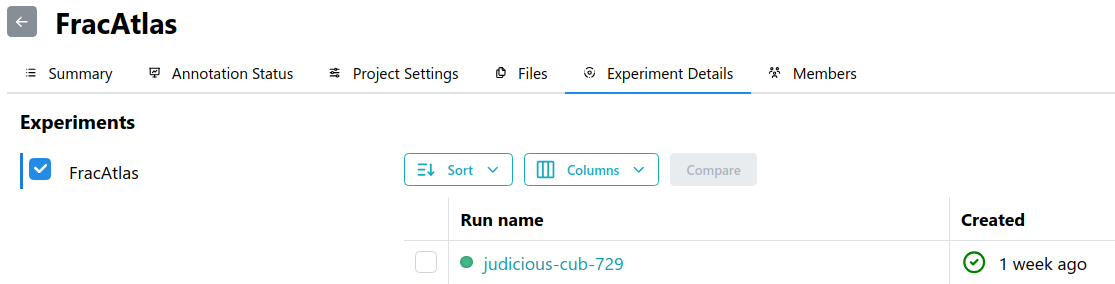

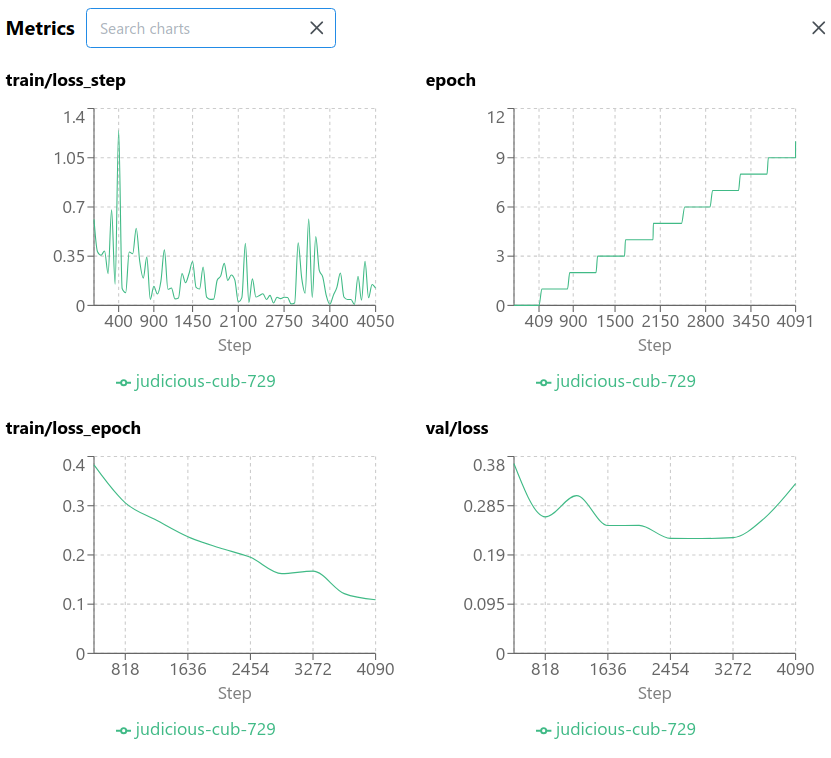

In [ ]:
# Open the Datamint project dashboard to view experiments and metrics
proj.show() # Display project details in Datamint platform

In [25]:
# Evaluate on test set and register the best model
# This step is required to trigger model registration automatically (see register_model_on='test' above)
trainer.test(dataloaders=test_dataloader)

# you can do the registration manually as well:
# mlflow.pytorch.log_model(model, registered_model_name=PROJECT_NAME)

[12/02/25 23:31:04] INFO     Restoring states from the checkpoint path at                ]8;id=782457;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py\checkpoint_connector.py]8;;\:]8;id=617126;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py#81\81]8;;\
                             /home/lhsmello/projects/Sonance/datamint-python-api/noteboo                           
                             ks/use_cases/1/a66f908a72104978bbc18a41350c70fb/checkpoints                           
                             /best.ckpt                                                                            

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


                    INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]                                   ]8;id=755216;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/accelerators/cuda.py\cuda.py]8;;\:]8;id=968477;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/accelerators/cuda.py#61\61]8;;\

                    INFO     Loaded model weights from the checkpoint at                ]8;id=143823;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py\checkpoint_connector.py]8;;\:]8;id=809920;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py#224\224]8;;\
                             /home/lhsmello/projects/Sonance/datamint-python-api/notebo                            
                             oks/use_cases/1/a66f908a72104978bbc18a41350c70fb/checkpoin                            
                             ts/best.ckpt                                                                          

Testing: |          | 0/? [00:00<?, ?it/s]

                    WARNING  Run ID mismatch: home != a66f908a72104978bbc18a41350c70fb.      ]8;id=917051;file:///home/lhsmello/projects/Sonance/datamint-python-api/datamint/mlflow/lightning/callbacks/modelcheckpoint.py\modelcheckpoint.py]8;;\:]8;id=184977;file:///home/lhsmello/projects/Sonance/datamint-python-api/datamint/mlflow/lightning/callbacks/modelcheckpoint.py#361\361]8;;\
                             Check `run_id` parameter in MLFlowLogger.                                             

Registered model 'FracAtlas' already exists. Creating a new version of this model...
2025/12/02 23:31:06 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: FracAtlas, version 2
Created version '2' of model 'FracAtlas'.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test/accuracy       │    0.9242053627967834     │
│         test/loss         │    0.23816800117492676    │
└───────────────────────────┴───────────────────────────┘

🏃 View run able-mule-249 at: http://localhost:5000/#/experiments/1/runs/a66f908a72104978bbc18a41350c70fb
🧪 View experiment at: http://localhost:5000/#/experiments/1


[{'test/loss': 0.23816800117492676, 'test/accuracy': 0.9242053627967834}]

## 4. Model Inference

### 4.1 Load and Predict with the Registered Model

We load the trained model from MLflow's Model Registry for prediction.

In [11]:
# Create a new trainer for prediction (no training setup needed)
import mlflow
import lightning as L
from torch.utils.data import DataLoader

pred_trainer = L.Trainer(
    enable_model_summary=True,
    enable_progress_bar=True,
)

print('Loading registered model from MLflow Model Registry...')
registered_model = mlflow.pytorch.load_model(f'models:/{PROJECT_NAME}/latest')
print('Model loaded successfully!')

# Set up data module for prediction (same as before, but without annotations)
test_dataset = FracAtlasDataset(all_proj_resources, split='test',
                                transforms=test_transforms, return_annotations=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

# Option 1: Use model already in memory
preds = pred_trainer.predict(
    registered_model,
    # ckpt_path=checkcb.best_model_path,  # Uncomment to load from checkpoint
    dataloaders=test_dataloader
)

# Option 2: Load from MLflow Model Registry (commented out)
# registered_model = mlflow.pytorch.load_model(f'models:/{PROJECT_NAME}/latest')
# preds = pred_trainer.predict(registered_model, dataloaders=test_dataloader)


print(f"✅ Predictions completed!")
print(f"First batch shape: {preds[0].shape}")
print(f'First batch, class with max probability: {preds[0].argmax(dim=1)}')

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


[12/02/25 23:42:00] INFO     💡 Tip: For seamless cloud uploads and versioning, try       ]8;id=800223;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/callback_connector.py\callback_connector.py]8;;\:]8;id=795356;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/callback_connector.py#108\108]8;;\
                             installing [litmodels](https://pypi.org/project/litmodels/)                           
                             to enable LitModelCheckpoint, which syncs automatically with                          
                             the Lightning model registry.                                                         

INFO: GPU available: True (cuda), used: True


                    INFO     GPU available: True (cuda), used: True                                    ]8;id=979578;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py\setup.py]8;;\:]8;id=413890;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py#156\156]8;;\

INFO: TPU available: False, using: 0 TPU cores


                    INFO     TPU available: False, using: 0 TPU cores                                  ]8;id=134206;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py\setup.py]8;;\:]8;id=581258;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py#159\159]8;;\

INFO: HPU available: False, using: 0 HPUs


                    INFO     HPU available: False, using: 0 HPUs                                       ]8;id=94623;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py\setup.py]8;;\:]8;id=540256;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py#169\169]8;;\

Loading registered model from MLflow Model Registry...


NameError: name 'PROJECT_NAME' is not defined

## 5. Model Deployment

For production use, we need to wrap our model in a **Datamint Model Adapter**. This adapter:
- Standardizes the input/output format
- Handles resource loading from Datamint
- Enables deployment via MLflow Model Serving or Datamint's inference API

### 5.1 Create a Datamint Model Adapter

The `DatamintModel` base class provides a consistent interface for model deployment. Override `predict_image()` to define how your model processes inputs and returns annotations.

In [14]:
from datamint.mlflow.flavors.model import DatamintModel
from datamint.entities.annotations import ImageClassification
from datamint.entities import Resource
import lightning as L
from torch.utils.data import DataLoader


class FracAtlasAdapter(DatamintModel):

    def __init__(self) -> None:
        # you can link to already saved models: `super().__init__(mlflow_models_uri={'pytorch_model': 'models:/FracAtlas/1'})`
        # Or set them here as attribute, which will be saved together with your adapter: `self.pytorch_model = your_model`

        # This line automatically loads the model from MLflow Model Registry, which can be accessed via `self.mlflow_models['pytorch_model']`
        super().__init__(mlflow_torch_models_uri={'pytorch_model': 'models:/FracAtlas/latest'},
                         settings={'need_gpu': False})

    def predict_image(self,
                      model_input: list[Resource],
                      **kwargs):
        # Use the same code, dataset and transforms as during testing! No rewrite needed!
        dataset = FracAtlasDataset(model_input, transforms=test_transforms, return_annotations=False)
        dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
        pytorch_model = self.get_mlflow_torch_models()['pytorch_model']  # torch.nn.Module
        pytorch_model.eval()
        # You can use ``L.Trainer`` here,
        # but we will use ``L.Fabric`` (very similar), a more lightweight and flexible version of it.

        predictor = L.Fabric()  # Way more lightweight and flexible than ``L.Trainer``
        predictor.to_device(self.inference_device)
        pytorch_model = predictor.setup_module(pytorch_model)
        dataloader = predictor.setup_dataloaders(dataloader)

        preds = []
        with torch.no_grad():
            for batch in dataloader:
                prob = pytorch_model(batch)
                # prob.shape: torch.Size([1, 2])
                # prob is in logits, let's convert to probabilities
                prob = torch.nn.functional.softmax(prob, dim=1)
                for p in prob:
                    max_idx = p.argmax()
                    val = 'yes' if max_idx == 1 else 'no'
                    annot = ImageClassification(name='has_fracture',
                                                value=val,
                                                confiability=float(p[max_idx])
                                                )
                    preds.append([annot])
        return preds

In [16]:
from datamint.mlflow.flavors import datamint_flavor
from datamint.mlflow import set_project
from mlflow import set_experiment
import mlflow

set_project(PROJECT_NAME)
set_experiment('FracAtlas_inference')  # Doesn't need to be a new experiment. Do whatever you feel is more organized.
dtmodel = FracAtlasAdapter()

with mlflow.start_run(run_name="adapting_fracatlas_model"):
    modelinfo = datamint_flavor.log_model(
        dtmodel,
        registered_model_name="FracAtlas_adapted",  # You almost always want to register this new adapter-model
    )

2025/12/02 23:43:36 INFO mlflow.models.signature: Inferring model signature from type hints
2025/12/02 23:43:36 INFO mlflow.models.signature: Failed to infer output type hint, setting output schema to AnyType. Unsupported type hint `<enum 'AnnotationType'>`. Type hints must be a list[...] where collection element type is one of these types: [<class 'int'>, <class 'str'>, <class 'bool'>, <class 'float'>, <class 'bytes'>, <class 'datetime.datetime'>], pydantic BaseModel subclasses, lists and dictionaries of primitive types, or typing.Any. Check https://mlflow.org/docs/latest/model/python_model.html#supported-type-hints for more details.
Registered model 'FracAtlas_adapted' already exists. Creating a new version of this model...
2025/12/02 23:43:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: FracAtlas_adapted, version 3


🏃 View run adapting_fracatlas_model at: http://localhost:5000/#/experiments/2/runs/87cdcaa97a8e46768cb9a87a3e130e9b
🧪 View experiment at: http://localhost:5000/#/experiments/2


Created version '3' of model 'FracAtlas_adapted'.


## 6. Testing logged model

### 6.1 Test the Logged Model Locally

Before deploying, verify that the model loads and predicts correctly.

In [17]:
import mlflow
from datamint.entities.resource import LocalResource

example_resource = LocalResource(
    'https://www.radiologymasterclass.co.uk/images/musculoskeletal-images/trauma/transverse_bone_fracture.jpg'
    # '/My/Local/file.jpeg'
)


loaded_model = mlflow.pyfunc.load_model('models:/FracAtlas_adapted/latest')
# loaded_model.predict(all_proj_resources[:2]) # just the first two resources
loaded_model.predict([example_resource]) # Or a local resource

INFO: You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


[12/02/25 23:43:48] INFO     You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor    ]8;id=165585;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/fabric/accelerators/cuda.py\cuda.py]8;;\:]8;id=924666;file:///home/lhsmello/projects/Sonance/datamint-python-api/.venv/lib/python3.12/site-packages/lightning/fabric/accelerators/cuda.py#166\166]8;;\
                             Cores. To properly utilize them, you should set                                       
                             `torch.set_float32_matmul_precision('medium' | 'high')` which will                    
                             trade-off precision for performance. For more details, read                           
                             https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precisi            
                             on.html#torch.set_float32_matmul_precision                                            

[[ImageClassification(identifier='has_fracture', scope='image', annotation_type=<AnnotationType.CATEGORY: 'category'>, confiability=0.9384037852287292, id=None, frame_index=None, text_value='yes', numeric_value=None, units=None, geometry=None, created_at=None, created_by=None, annotation_worklist_id=None, status=None, approved_at=None, approved_by=None, resource_id=None, associated_file=None, deleted=False, deleted_at=None, deleted_by=None, created_by_model=None, set_name=None, resource_filename=None, resource_modality=None, annotation_worklist_name=None, user_info=None, file=None)]]

> [!TIP]
> You can retrieve the adapter instance for debugging:
> ```python
> my_retrieved_adapter = loaded_model.unwrap_python_model()
> print(type(my_retrieved_adapter))  # <class 'FracAtlasAdapter'>
> ```

### 6.2 Serve the Model with MLflow

Serve the model locally via REST API:

```bash
mlflow models serve -m "models:/FracAtlas_adapted/latest" -p 5111 --env-manager virtualenv
```

In [ ]:
# Example: Send a prediction request to the model server
import json
import requests
from datamint.entities.resource import LocalResource

example_resource = LocalResource(
    'https://www.radiologymasterclass.co.uk/images/musculoskeletal-images/trauma/transverse_bone_fracture.jpg'
    # '/My/Local/file.jpeg'
)

payload = json.dumps(
    {
        "inputs": [example_resource.model_dump(mode='json')],
    }
)
response = requests.post(
    url=f"http://localhost:5111/invocations",
    data=payload,
    headers={"Content-Type": "application/json"},
)
response.json()

## Deploying

## Summary

In this notebook, we demonstrated a complete ML pipeline for medical image classification:

| Step | Description |
|------|-------------|
| **Data Management** | Uploaded 4,000+ images to Datamint with tags and annotations |
| **Dataset Creation** | Built a PyTorch Dataset that integrates with Datamint's API |
| **Model Training** | Fine-tuned ResNet-18 with PyTorch Lightning |
| **Experiment Tracking** | Logged metrics and models with MLflow integration |
| **Model Deployment** | Created a deployable adapter for inference |

### See Also

- [Datamint Documentation](https://sonanceai.github.io/datamint-python-api/)
- [FracAtlas Paper](https://doi.org/10.1038/s41597-023-02432-4)
- [PyTorch Lightning Guide](https://lightning.ai/docs/pytorch/stable/)
- [MLflow Model Registry](https://mlflow.org/docs/latest/model-registry.html)